### library load

In [13]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import base64
from statsmodels.stats.outliers_influence import variance_inflation_factor

## data load

### edit feature

  - delete 'next_speaker'
  
  - groupy by records

In [14]:
df = pd.read_csv('data\dataset_collaboration_with_survey_scores.csv')
df

,id,project,meeting_number,speaker_number,speech_frequency,total_words,duration,normalized_speech_frequency,speaker_id,next_speaker_id,...,interaction_equality_index,degree_centrality,indegree_centrality,outdegree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,overall_collaboration_score,individual_collaboration_score
0,3_1_SPEAKER_00,3,1,0,22,8731,1.633333,13.469388,0,0,...,0.009704,0.000094,0.000047,0.000047,0.000000,9.518792e-08,0.000000,2.907995e-06,-1.0,-1.0
1,3_1_SPEAKER_00,3,1,0,22,8731,1.633333,13.469388,0,1,...,0.009704,0.000094,0.000047,0.000047,0.000000,9.518792e-08,0.000000,2.907995e-06,-1.0,-1.0
2,3_1_SPEAKER_00,3,1,0,22,8731,1.633333,13.469388,0,2,...,0.009704,0.000094,0.000047,0.000047,0.000000,9.518792e-08,0.000000,2.907995e-06,-1.0,-1.0
3,3_1_SPEAKER_00,3,1,0,22,8731,1.633333,13.469388,0,3,...,0.009704,0.000094,0.000047,0.000047,0.000000,9.518792e-08,0.000000,2.907995e-06,-1.0,-1.0
4,3_1_SPEAKER_01,3,1,1,645,8731,1.633333,394.897959,1,0,...,0.009704,0.166808,0.083381,0.083428,0.000051,9.523587e-08,0.000000,3.007661e-05,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,4_17_SPEAKER_04,4,17,4,1157,15573,2.866667,403.604651,4,0,...,0.405638,0.042055,0.021028,0.021028,0.000000,4.129354e-08,0.000002,8.073990e-07,10.0,8.0
523,4_17_SPEAKER_04,4,17,4,1157,15573,2.866667,403.604651,4,1,...,0.405638,0.042055,0.021028,0.021028,0.000000,4.129354e-08,0.000002,8.073990e-07,10.0,7.0
524,4_17_SPEAKER_04,4,17,4,1157,15573,2.866667,403.604651,4,2,...,0.405638,0.042055,0.021028,0.021028,0.000000,4.129354e-08,0.000002,8.073990e-07,10.0,8.0
525,4_17_SPEAKER_04,4,17,4,1157,15573,2.866667,403.604651,4,3,...,0.405638,0.042055,0.021028,0.021028,0.000000,4.129354e-08,0.000002,8.073990e-07,10.0,9.0


In [15]:
df['num_speakers'] = df.groupby(['project', 'meeting_number'])[
    'speaker_id'].transform('nunique')

# Ensure interaction_count column exists
df['interaction_count'] = df['count']
if 'interaction_count' not in df.columns:
    df['interaction_count'] = 0  # Or some appropriate default value

df['normalized_interaction_frequency'] = df['interaction_count'] / \
    df['duration']

In [16]:
df = df[(df['project'] == 4) & (
    df['overall_collaboration_score'].between(1, 10))]

df_grouped = df.groupby(['project', 'meeting_number', 'speaker_id']).agg({
    'normalized_speech_frequency': 'first',
    'gini_coefficient': 'first',
    'degree_centrality': 'first',
    'num_speakers': 'first',
    'normalized_interaction_frequency': 'sum',
    'overall_collaboration_score': 'first'
}).reset_index()
df_grouped

,project,meeting_number,speaker_id,normalized_speech_frequency,gini_coefficient,degree_centrality,num_speakers,normalized_interaction_frequency,overall_collaboration_score
0,4,1,0,652.436975,0.401351,0.098437,5,29.747899,3.0
1,4,1,1,358.487395,0.401351,0.013715,5,12.605042,2.0
2,4,1,2,302.521008,0.401351,0.014887,5,13.109244,3.0
3,4,1,3,4459.159664,0.401351,0.141710,5,79.159664,3.0
4,4,1,4,289.411765,0.401351,0.020269,5,14.621849,2.0
...,...,...,...,...,...,...,...,...,...
80,4,17,0,741.976744,0.309514,0.061783,5,52.674419,9.0
81,4,17,1,637.674419,0.309514,0.103946,5,70.116279,7.0
82,4,17,2,200.232558,0.309514,0.009210,5,21.976744,9.0
83,4,17,3,3448.953488,0.309514,0.200108,5,138.139535,9.0


In [17]:
df_grouped.columns

Index(['project', 'meeting_number', 'speaker_id',
       'normalized_speech_frequency', 'gini_coefficient', 'degree_centrality',
       'num_speakers', 'normalized_interaction_frequency',
       'overall_collaboration_score'],
      dtype='object')

In [18]:
# Filter dataset for project 4 and overall_collaboration_score between 1 and 10

# Cleaning the dataset
df_grouped = df_grouped.replace([np.inf, -np.inf], np.nan)
df_grouped = df_grouped.dropna()

# Features and target
features = df_grouped[['meeting_number', 'normalized_speech_frequency', 'gini_coefficient',
                       'degree_centrality', 'num_speakers', 'normalized_interaction_frequency', 'speaker_id']]
target = df_grouped['overall_collaboration_score']

df_grouped

,project,meeting_number,speaker_id,normalized_speech_frequency,gini_coefficient,degree_centrality,num_speakers,normalized_interaction_frequency,overall_collaboration_score
0,4,1,0,652.436975,0.401351,0.098437,5,29.747899,3.0
1,4,1,1,358.487395,0.401351,0.013715,5,12.605042,2.0
2,4,1,2,302.521008,0.401351,0.014887,5,13.109244,3.0
3,4,1,3,4459.159664,0.401351,0.141710,5,79.159664,3.0
4,4,1,4,289.411765,0.401351,0.020269,5,14.621849,2.0
...,...,...,...,...,...,...,...,...,...
80,4,17,0,741.976744,0.309514,0.061783,5,52.674419,9.0
81,4,17,1,637.674419,0.309514,0.103946,5,70.116279,7.0
82,4,17,2,200.232558,0.309514,0.009210,5,21.976744,9.0
83,4,17,3,3448.953488,0.309514,0.200108,5,138.139535,9.0


In [19]:
column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['meeting_number', 'normalized_speech_frequency',
         'gini_coefficient', 'degree_centrality', 'num_speakers', 'normalized_interaction_frequency']),
        ('onehot', OneHotEncoder(), ['speaker_id'])
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'LightGBM Regressor': LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost Regressor': CatBoostRegressor(random_state=42, verbose=0),
    'SVM Regressor': SVR()
}

param_grids_regression = {
    'Linear Regression': {},
    'Decision Tree': {'model__max_depth': [3, 5, 7]},
    'Random Forest Regressor': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBRegressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7], 'model__learning_rate': [0.01, 0.1, 0.2]},
    'Gradient Boosting Regressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1, 0.2, 0.5]},
    'K-Nearest Neighbors Regressor': {'model__n_neighbors': [3, 5, 7]},
    'LightGBM Regressor': {'model__n_estimators': [50, 100, 200], 'model__num_leaves': [31, 62], 'model__learning_rate': [0.01, 0.1, 0.3]},
    'CatBoost Regressor': {'model__iterations': [100, 200, 400], 'model__depth': [4, 6, 10]},
    'SVM Regressor': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
}

In [20]:
def find_best_hyperparameters_regression(X_train, y_train, X_test, y_test):
    best_r2 = -float('inf')
    best_model_info = {}
    model_performance = []

    for model_name, model in regression_models.items():
        start_time = time.time()
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('model', model)
        ])
        grid = GridSearchCV(
            pipeline, param_grids_regression[model_name], cv=3, scoring='r2')
        grid.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time

        y_pred = grid.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            grid.best_estimator_, X_train, y_train, cv=kf, scoring='r2')
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        model_performance.append({
            'Model': model_name,
            'R2': round(r2, 2),
            'MSE': round(mse, 2),
            'CV Mean': round(mean_cv_score, 2),
            'CV Std': round(std_cv_score, 2),
            'Training Time': round(training_time, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_model_info = {
                'model': model_name,
                'r2': round(r2, 2),
                'mse': round(mse, 2),
                'cv_mean_r2': round(mean_cv_score, 2),
                'cv_std_r2': round(std_cv_score, 2),
                'params': grid.best_params_,
                'training_time': round(training_time, 2),
                'model_object': grid.best_estimator_
            }

    return best_model_info, model_performance


best_reg_model_info, model_performance = find_best_hyperparameters_regression(
    X_train, y_train, X_test, y_test)

In [21]:
best_reg_model_info

{'model': 'Gradient Boosting Regressor',
 'r2': 0.85,
 'mse': 0.97,
 'cv_mean_r2': 0.72,
 'cv_std_r2': 0.1,
 'params': {'model__learning_rate': 0.1,
  'model__max_depth': 3,
  'model__n_estimators': 50},
 'training_time': 1.94,
 'model_object': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                   ['meeting_number',
                                                    'normalized_speech_frequency',
                                                    'gini_coefficient',
                                                    'degree_centrality',
                                                    'num_speakers',
                                                    'normalized_interaction_frequency']),
                                                  ('onehot', OneHotEncoder(),
                                                   ['speaker_id'])])),
                 ('model',
           

In [22]:
def predict_and_evaluate(best_reg_model_info, X_train, y_train, X_test, y_test):
    best_model = best_reg_model_info['model_object']
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    results_with_test_df = pd.concat(
        [X_test.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

    # plt.figure(figsize=(10, 8))
    # sns.scatterplot(x='Actual', y='Predicted', data=results_df)
    # plt.plot([results_df.min().min(), results_df.max().max()], [results_df.min().min(), results_df.max().max()], color='red', linewidth=2)
    # plt.title('Actual vs Predicted Values')
    # plt.savefig('actual_vs_predicted.png')
    # plt.show()

    return results_with_test_df


results_df = predict_and_evaluate(
    best_reg_model_info, X_train, y_train, X_test, y_test)
results_df

,meeting_number,normalized_speech_frequency,gini_coefficient,degree_centrality,num_speakers,normalized_interaction_frequency,speaker_id,Actual,Predicted
0,16,3982.025316,0.177971,0.184716,5,148.860759,3,9.0,8.576649
1,1,652.436975,0.401351,0.098437,5,29.747899,0,3.0,2.632712
2,14,3953.454545,0.415748,0.124639,5,98.181818,3,6.0,6.439993
3,5,183.243243,0.420915,0.007840,5,8.648649,2,5.0,3.920785
4,3,415.789474,0.288193,0.017212,5,18.947368,2,3.0,2.455757
5,17,200.232558,0.309514,0.009210,5,21.976744,2,9.0,9.282851
6,3,1063.684211,0.288193,0.102913,5,47.368421,0,2.0,2.405070
7,4,4254.000000,0.752303,0.110618,5,737.000000,3,3.0,3.951528
8,1,289.411765,0.401351,0.020269,5,14.621849,4,2.0,2.773509
9,14,239.454545,0.415748,0.001786,5,9.272727,1,6.0,6.897675


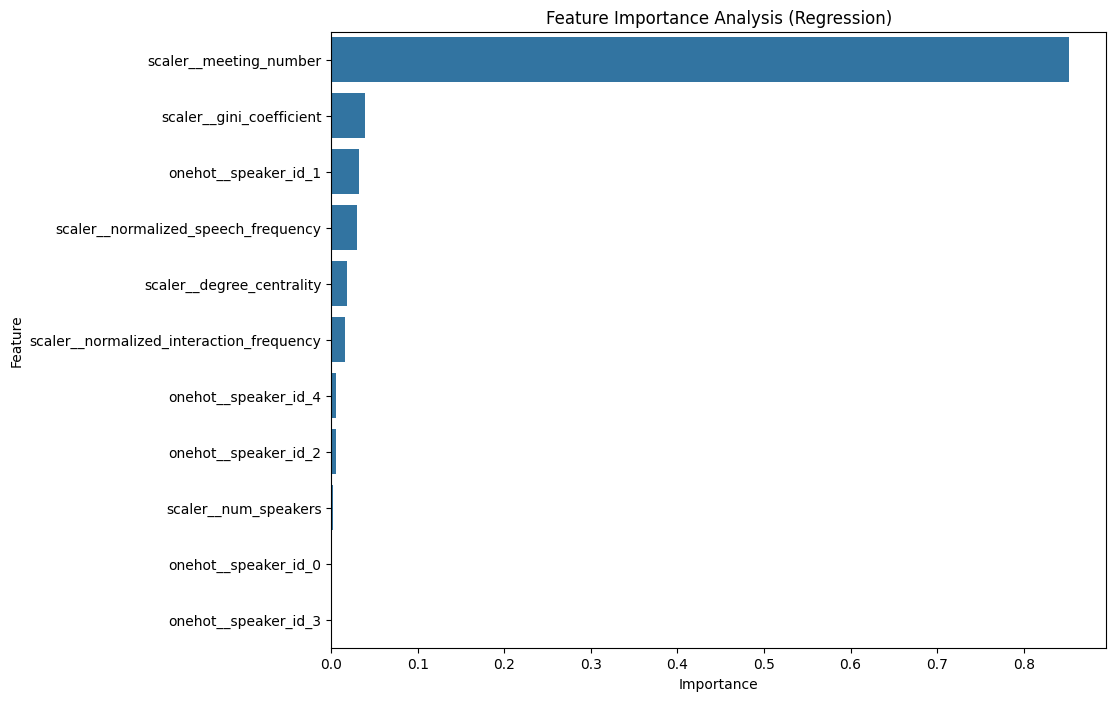

,Model,Parameters
0,Decision Tree,"max_depth: [3, 5, 7]"
1,Random Forest Regressor,"n_estimators: [50, 100, 150], max_depth: [5, 1..."
2,XGBRegressor,"n_estimators: [50, 100], max_depth: [3, 5, 7],..."
3,Gradient Boosting Regressor,"n_estimators: [50, 100], max_depth: [3, 5], le..."
4,K-Nearest Neighbors Regressor,"n_neighbors: [3, 5, 7]"
5,LightGBM Regressor,"n_estimators: [50, 100, 200], num_leaves: [31,..."
6,CatBoost Regressor,"iterations: [100, 200, 400], depth: [4, 6, 10]"
7,SVM Regressor,"C: [0.1, 1, 10], kernel: [linear, rbf]"


In [23]:
# Multicollinearity Check (VIF)
X_vif = pd.DataFrame(column_transformer.fit_transform(
    features), columns=column_transformer.get_feature_names_out())
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [round(variance_inflation_factor(
    X_vif.values, i), 2) for i in range(X_vif.shape[1])]

# Feature Importance
if hasattr(best_reg_model_info['model_object'].named_steps['model'], 'feature_importances_'):
    best_model = best_reg_model_info['model_object'].named_steps['model']
    feature_importances_reg = best_model.feature_importances_

    importance_df_reg = pd.DataFrame(
        {'Feature': column_transformer.get_feature_names_out(), 'Importance': feature_importances_reg})
    importance_df_reg = importance_df_reg.sort_values(
        by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_reg)
    plt.title('Feature Importance Analysis (Regression)')
    plt.savefig('feature_importance.png')
    plt.show()

# Model Performance Table
model_performance_df = pd.DataFrame(model_performance)

# Hyperparameter details
hyperparameter_details = [
    {'Model': 'Decision Tree', 'Parameters': 'max_depth: [3, 5, 7]'},
    {'Model': 'Random Forest Regressor',
        'Parameters': 'n_estimators: [50, 100, 150], max_depth: [5, 10, 15]'},
    {'Model': 'XGBRegressor',
        'Parameters': 'n_estimators: [50, 100], max_depth: [3, 5, 7], learning_rate: [0.01, 0.1, 0.2]'},
    {'Model': 'Gradient Boosting Regressor',
        'Parameters': 'n_estimators: [50, 100], max_depth: [3, 5], learning_rate: [0.01, 0.1, 0.2, 0.5]'},
    {'Model': 'K-Nearest Neighbors Regressor',
        'Parameters': 'n_neighbors: [3, 5, 7]'},
    {'Model': 'LightGBM Regressor',
        'Parameters': 'n_estimators: [50, 100, 200], num_leaves: [31, 62], learning_rate: [0.01, 0.1, 0.3]'},
    {'Model': 'CatBoost Regressor',
        'Parameters': 'iterations: [100, 200, 400], depth: [4, 6, 10]'},
    {'Model': 'SVM Regressor',
        'Parameters': 'C: [0.1, 1, 10], kernel: [linear, rbf]'}
]

hyperparameter_df = pd.DataFrame(hyperparameter_details)
hyperparameter_df